# Predicting Used Cars Sale Price
Buying and selling a car are important decision as prices are usually high, even for used cars. For this reason, it's important for sellers to be able to estimate their car at a right price and avoid underestimation, as for buyers to avoid choosing a car that is selling above their expected value.

### Objective
The purpose of this project is to predict sale price of used cars based on different characteristics of a given car.

### Performance
To do so, a regression model will be built and tuned in order to minimise the error of prediction. The performance will be measured by:
* **RMSE:** Root Squared of the Mean Squared Error. It is calculated by the sum of square of prediction error: $\sum(\hat{y}-y)^2/N$. Less robust to outliers, it gives a higher weight to large errors (as all errors are squared).
* **MAE:** Mean Absolute Error. It is the sum of the average absolute errors, this means that positive and negative errors cancel each other out. However, this also means that the effect of outliers is reduced with respect to RMSE. 
* **R2:** "*proportion of the variation in the dependent variable that is predictable from the independent variable.*" (source: Wikipedia)

===================================================================================================

# Model Training
===================================================================================================

# Import Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


# Regression algorithms
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor


# Fine tuning models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


# Saving models
import pickle 

# Load preprocessed data

In [2]:
X_train = pd.read_csv('xtrain_preprocessed.csv')
y_train = pd.read_csv('ytrain_preprocessed.csv')

In [3]:
X_train.join(y_train).head()

,Years,Brand,Kms,Emiss_CO2,Cons_litres_100km,Doors,Power_CV,Seats,Years_na,Kms_na,...,Fuel_Diesel,Fuel_Essence,Fuel_Other,Transmission_Automatique,Transmission_Manuelle,Transmission_Other,Brand_origin_other,Brand_origin_germany,Brand_origin_france,Prices
0,0.962264,0.049436,0.744246,0.134504,0.065567,0.4,0.875,0.428571,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,10.368793
1,0.952830,0.140927,0.674278,0.134504,0.065567,0.4,0.500,0.428571,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,9.797571
2,0.981132,0.441721,0.596450,0.134504,0.065567,0.4,0.875,0.428571,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,10.668723
3,0.962264,0.529870,0.743119,0.134504,0.055000,0.4,0.625,0.428571,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,9.674074
4,0.990566,1.000000,0.645076,0.149000,0.065567,0.6,0.500,0.428571,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.560293


In [4]:
X_train.shape, y_train.shape

((43717, 25), (43717, 1))

In [5]:
y_train = y_train.values.ravel()
y_train.shape

(43717,)

# First round of modelling

## Setting things up
* **Metrics**
To assess performance:
   * **Mean Square Error (MSE) / Root MSE (RMSE)**
       * Calculated by the sum of square of prediction error: $\sum(\hat{y}-y)^2/N$. Less robust to outliers, but more computation efficient.
   * **Mean Absolute Error (MAE)**
       * More robust to outliers.
   * **R2**
       * R2 is a measure of ...
       
* **Models**
    * Using mostly the sklearn library, different regression models will be tested as benchmark (the best ones will be later fine-tuned)
* **Scores**
    * An empty list will be created to keep the scores of each metric, for each model

In [6]:
metrics = ['neg_root_mean_squared_error','neg_mean_absolute_error', 'r2']

In [7]:
models = []
scores = []

## Exploring models

In [8]:
%%time
classes = [LinearRegression(), 
              KNeighborsRegressor(),
              SVR(),
              DecisionTreeRegressor(random_state = 42),
              ExtraTreesRegressor(random_state = 42),
              RandomForestRegressor(random_state = 42),
              AdaBoostRegressor(random_state = 42),
              GradientBoostingRegressor(random_state = 42),
              XGBRegressor(random_state = 42)]


for model in classes:
    model.fit(X_train, y_train)
    
    cross_val = cross_validate(model, X_train, y_train, scoring = metrics)

    models.append(f'{model.__class__.__name__}')
    scores.append(list(cross_val.values())[2:])

Wall time: 24min 6s


In [9]:
data = []
for i in range(len(models)):
    for j in range(len(metrics)):
        data.append(scores[i][j].mean())

data = np.reshape(data, (len(models), len(metrics)))
        
df_models = pd.DataFrame(data, index = models, columns = metrics)
df_models.style.highlight_max(color = 'lightgreen', axis = 0)

,neg_root_mean_squared_error,neg_mean_absolute_error,r2
LinearRegression,-0.472080,-0.341769,0.608749
ElasticNet,-0.755006,-0.565803,-0.000111
SGDRegressor,-0.474853,-0.347124,0.604215
KNeighborsRegressor,-0.348613,-0.220746,0.786753
SVR,-0.334839,-0.214877,0.803103
DecisionTreeRegressor,-0.323382,-0.198020,0.816436
ExtraTreesRegressor,-0.235138,-0.150527,0.902986
RandomForestRegressor,-0.236677,-0.150575,0.901715
AdaBoostRegressor,-0.447396,-0.344287,0.648657
GradientBoostingRegressor,-0.300262,-0.207499,0.841740


# Fine Tuned models

In [10]:
fine_tuned_models = []
new_models = []
new_scores = []

## ExtraTreesRegressor

In [11]:
%%time

'''ExtraTreesRegressor
parameters: 
    n_estimators: number of trees in the forest; (default = 100)
                    generally random forests do not overfit as more trees are added, however, the increase on
                    performance does not necessarily justifies the increase on complexity (more time/resources)
                    
    max_depth: maximum depth of each tree in the forest; (default = None, all leaves are expanded as much as possible)
                    generally, the deeper the tree, the more splits, which can lead to higher performance, as it
                    allows the model to better fit the data (lower bias), however this can also lead to higher
                    variance as the model can start to overfit the training data
    
    min_samples_split: minimum number of samples required to split an internal node; (default = 2)
                    this can reduce the number of splits, which can reduce overfitting, however, if too large, it
                    can also lead to underfitting the training set
    
    min_samples_leaf: mininum number of samples that must be present in a leaf/terminal node (end of the tree); (default = 1)
                    as before, a higher value can reduce overfitting but a too high value can lead to underfitting.
                    Specially in regression, a higher value can also smooth the model, by avoiding leaves with only one value
                    
    max_features: number of features to consider for best split (deafault = 'auto', total number of features)
                    a higher number will lead to better performance, but a too high number will also lead to overfitting.
                    Moreover, the higher the number, the more computationally expensive the model becomes.
    
    max_samples: number (or %) of samples to draw from X to train each base estimator (default = None, total num of samples)
                     The lower the value, the more randomness is introduced to the data.
                     --Only possible if Bootstrap = True.
    '''

param_grid = {'n_estimators':[ 350], #200, 250,
              'max_depth':[16, 24, 32],
              'min_samples_split':[2, 3, 4],
              'min_samples_leaf':[1, 2, 3],
              'max_features':[15, 20, 25],
              'max_samples':[0.8, 0.9, 1.0],
              'bootstrap':[True],
              'n_jobs':[-1],
              'random_state':[42]}

et_gd = GridSearchCV(estimator = ExtraTreesRegressor(),
                      param_grid = param_grid, 
                      cv = 5, 
                      scoring = metrics,
                      refit = 'neg_mean_absolute_error',
                      error_score = 'raise', 
                      verbose = 2)
                     
et_gd.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=  11.1s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.4s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.7s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.7s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.7s
[CV] END bootstrap=True, max_depth=16, ma

[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.1s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.7s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.6s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.5s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.4s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_

[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.8s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.9s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.2s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.4s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.1s
[CV] END bootstrap=True, max_depth=16, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_

[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.8s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.8, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.6s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.8, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.9s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.8, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.0s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.8, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   5.9s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.8, min_samples_leaf=1, min_samples_

[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.9, min_samples_leaf=1, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   5.5s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.9, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.9s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.9, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.5s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.9, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.9s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.9, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.5s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=0.9, min_samples_leaf=1, min_samples_

[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=1.0, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   5.8s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=1.0, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   5.6s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=1.0, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   5.4s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=1.0, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   5.3s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=1.0, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   5.5s
[CV] END bootstrap=True, max_depth=16, max_features=20, max_samples=1.0, min_samples_leaf=1, min_samples_

[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.8, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.3s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.8, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.7s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.8, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.4s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.8, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.2s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.8, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.0s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.8, min_samples_leaf=1, min_samples_

[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.9, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.9, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.9, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.9, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.9, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.4s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=0.9, min_samples_leaf=1, min_samples_

[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=1.0, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.2s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=1.0, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.8s
[CV] END bootstrap=True, max_depth=16, max_features=25, max_samples=1.0, min_samples_leaf=1, min_samples_

[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.2s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.8, min_samples_leaf=1, min_samples_

[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.4s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.9, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.4s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=0.9, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.8s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.9s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.9s
[CV] END bootstrap=True, max_depth=24, max_features=15, max_samples=1.0, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.8, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.8, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.8s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.8, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.1s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.8, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.9, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.3s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.9, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.3s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.0s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.3s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.4s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=1.0, min_samples_leaf=1, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.0s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=24, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.8s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.9s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.1s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.3s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.9s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.0s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.8s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.9s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.5s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.5s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.2s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.4s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.3s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.5s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.8s
[CV] END bootstrap=True, max_depth=24, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.0s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.8, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.1s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.1s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.2s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.8, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.9, min_samples_leaf=2, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.9, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.4s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.9, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.9, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.9, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.4s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=0.9, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.4s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.7s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.7s
[CV] END bootstrap=True, max_depth=32, max_features=15, max_samples=1.0, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.4s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.3s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.4s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.8, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.8s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.8s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.7s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.7s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.5s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=0.9, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.5s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.5s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.4s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.7s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.9s
[CV] END bootstrap=True, max_depth=32, max_features=20, max_samples=1.0, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=3, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.7s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.7s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.7s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.6s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.8, min_samples_leaf=2, min_samples_

[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.3s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.1s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.2s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.1s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.9, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   4.1s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=0.9, min_samples_leaf=3, min_samples_

[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.9s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.0s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.0s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=1.0, min_samples_leaf=2, min_samples_split=4, n_estimators=350, n_jobs=-1, random_state=42; total time=   3.0s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=1.0, min_samples_leaf=3, min_samples_split=2, n_estimators=350, n_jobs=-1, random_state=42; total time=   2.8s
[CV] END bootstrap=True, max_depth=32, max_features=25, max_samples=1.0, min_samples_leaf=3, min_samples_

GridSearchCV(cv=5, error_score='raise', estimator=ExtraTreesRegressor(),
             param_grid={'bootstrap': [True], 'max_depth': [16, 24, 32],
                         'max_features': [15, 20, 25],
                         'max_samples': [0.8, 0.9, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4], 'n_estimators': [350],
                         'n_jobs': [-1], 'random_state': [42]},
             refit='neg_mean_absolute_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'],
             verbose=2)

<!-- # Getting predicted values
y_pred = model.predict(X_train)

# Transforming back to original scale
y_pred = np.square(y_pred)
y_train = np.square(y_train)

# Getting metrics
rmse = mean_squared_error(y_train, y_pred, squared=False)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print('rmse:',rmse)
print('mae',mae)
print('r2',r2) -->

In [12]:
filename = 'ETRegressor.pkl'
pickle.dump(et_gd.best_estimator_, open(filename, 'wb'))

In [13]:
fine_tuned_models.append(et_gd.best_estimator_)
et_gd.best_params_

{'bootstrap': True,
 'max_depth': 24,
 'max_features': 20,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 350,
 'n_jobs': -1,
 'random_state': 42}

## XGBRegressor

In [14]:
%%time
# https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=xgboost%20xgbregressor#xgboost.XGBRegressor
'''XGBRegressor
parameters: 
    n_estimators: number of gradient boosted trees;
                    
    max_depth: maximum depth of each tree; (default = 6)
                    a higher value leads to a more complex model, more likely to overfit.
    
    learning_rate: boosting learning rate; (default = 0.3)
                    it shrinks the feature weights to make the boosting process more conservative. It prevents overfitting.
    
    subsample: subsample ratio if the training instances; (default = 1)
                    a lower value can help prevent overfitting.
   
    colsample_bytree: subsample ratio of columns (features) when constructing each tree; (default = 1)
                    similar to max_features in RandomForest/ExtraTrees
                    
    reg_alpha: L1 regularization term on weights; (default = 1)
                    increasing this value can prevent overfitting
                    
    reg_lambda: L2 regularization term on weights; (default = 0)
                    increasing this value can prevent overfitting
    '''

param_grid = {'n_estimators':[350],
              'max_depth':[16, 20],
              'learning_rate':[0.04, 0.06],
              'subsample':[0.9, 1.0],
              'colsample_bytree':[0.6, 0.7],
              'reg_alpha':[1.0, 1.3],
              'reg_lambda':[0.7, 1.0],
              'n_jobs':[-1],
              'random_state':[42]}

xgb_gd = GridSearchCV(estimator = XGBRegressor(),
                      param_grid = param_grid, 
                      cv = 4, 
                      scoring = metrics,
                      refit = 'neg_root_mean_squared_error',
                      error_score = 'raise', 
                      verbose = 2)
                     
xgb_gd.fit(X_train, y_train)

Fitting 4 folds for each of 64 candidates, totalling 256 fits
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=0.7, subsample=0.9; total time=  12.1s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=0.7, subsample=0.9; total time=  12.0s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=0.7, subsample=0.9; total time=  11.7s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=0.7, subsample=0.9; total time=  12.0s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=0.7, subsample=1.0; total time=  11.0s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_dep

[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=1.0; total time=  12.7s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=0.7, subsample=0.9; total time=  12.4s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=0.7, subsample=0.9; total time=  13.0s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=0.7, subsample=0.9; total time=  12.6s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=0.7, subsample=0.9; total time=  14.8s
[CV] END colsample_bytree=0.6, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha

[CV] END colsample_bytree=0.6, learning_rate=0.06, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=1.0, subsample=1.0; total time=  11.6s
[CV] END colsample_bytree=0.6, learning_rate=0.06, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=1.0, subsample=1.0; total time=  13.1s
[CV] END colsample_bytree=0.6, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=0.7, subsample=0.9; total time=  13.6s
[CV] END colsample_bytree=0.6, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=0.7, subsample=0.9; total time=  15.5s
[CV] END colsample_bytree=0.6, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=0.7, subsample=0.9; total time=  13.9s
[CV] END colsample_bytree=0.6, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha

[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=1.0; total time=  10.5s
[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=1.0; total time=  10.4s
[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=1.0; total time=  10.5s
[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=0.7, subsample=0.9; total time=  10.6s
[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=0.7, subsample=0.9; total time=  10.6s
[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha

[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=1.0, subsample=1.0; total time=  13.3s
[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=1.0, subsample=1.0; total time=  13.9s
[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=1.0, subsample=1.0; total time=  13.3s
[CV] END colsample_bytree=0.7, learning_rate=0.04, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.3, reg_lambda=1.0, subsample=1.0; total time=  13.3s
[CV] END colsample_bytree=0.7, learning_rate=0.06, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=0.7, subsample=0.9; total time=  12.3s
[CV] END colsample_bytree=0.7, learning_rate=0.06, max_depth=16, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha

[CV] END colsample_bytree=0.7, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=0.9; total time=  14.9s
[CV] END colsample_bytree=0.7, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=1.0; total time=  14.9s
[CV] END colsample_bytree=0.7, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=1.0; total time=  15.6s
[CV] END colsample_bytree=0.7, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=1.0; total time=  14.6s
[CV] END colsample_bytree=0.7, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha=1.0, reg_lambda=1.0, subsample=1.0; total time=  15.0s
[CV] END colsample_bytree=0.7, learning_rate=0.06, max_depth=20, n_estimators=350, n_jobs=-1, random_state=42, reg_alpha

GridSearchCV(cv=4, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monoton...
                                    validate_parameters=None, verbosity=None),
             param_grid={'colsample_bytree': [0.6, 0.7],
                         'learning_rate': [0.04, 0.06], 'max_depth': [16, 20],
                         'n_estimators': [350], 'n_jobs': [-1],
             

In [15]:
fine_tuned_models.append(xgb_gd.best_estimator_)
xgb_gd.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.06,
 'max_depth': 16,
 'n_estimators': 350,
 'n_jobs': -1,
 'random_state': 42,
 'reg_alpha': 1.0,
 'reg_lambda': 0.7,
 'subsample': 0.9}

<!-- d = xgb_gd.best_params_

for key,value in d.items():
    print('  ' + key + ': ' + str(value)) -->

In [16]:
filename = 'XGBRegressor.pkl'
pickle.dump(xgb_gd.best_estimator_, open(filename, 'wb'))

### Comparing models

In [17]:
%%time
for model in fine_tuned_models:
    cross_val = cross_validate(model, X_train, y_train, cv= 3, scoring = metrics)

    new_models.append(f'{model.__class__.__name__}')
    new_scores.append(list(cross_val.values())[2:])
    print('')

data = []
for model in range(len(fine_tuned_models)):
    for score in range(len(metrics)):
        data.append(new_scores[model][score].mean())

data = np.reshape(data, (len(fine_tuned_models), len(metrics)))
        
df_models = pd.DataFrame(data, index = new_models, columns = metrics)



Wall time: 44.9 s


In [18]:
df_models.style.highlight_max(color = 'lightgreen', axis = 0)

,neg_root_mean_squared_error,neg_mean_absolute_error,r2
ExtraTreesRegressor,-0.232017,-0.149797,0.905553
XGBRegressor,-0.218059,-0.142482,0.916563


### Plotting feature importance

In [19]:
df_model = pd.DataFrame(
{
    'features':X_train.columns,
    'importance': xgb_gd.best_estimator_.feature_importances_
})
df_model = df_model.sort_values(by = ['importance'], ascending = False)
df_model

,features,importance
20,Transmission_Manuelle,0.340334
15,Luxury_brand,0.263061
23,Brand_origin_germany,0.069178
19,Transmission_Automatique,0.064078
0,Years,0.053000
6,Power_CV,0.039852
24,Brand_origin_france,0.032644
22,Brand_origin_other,0.023107
2,Kms,0.017554
1,Brand,0.016418


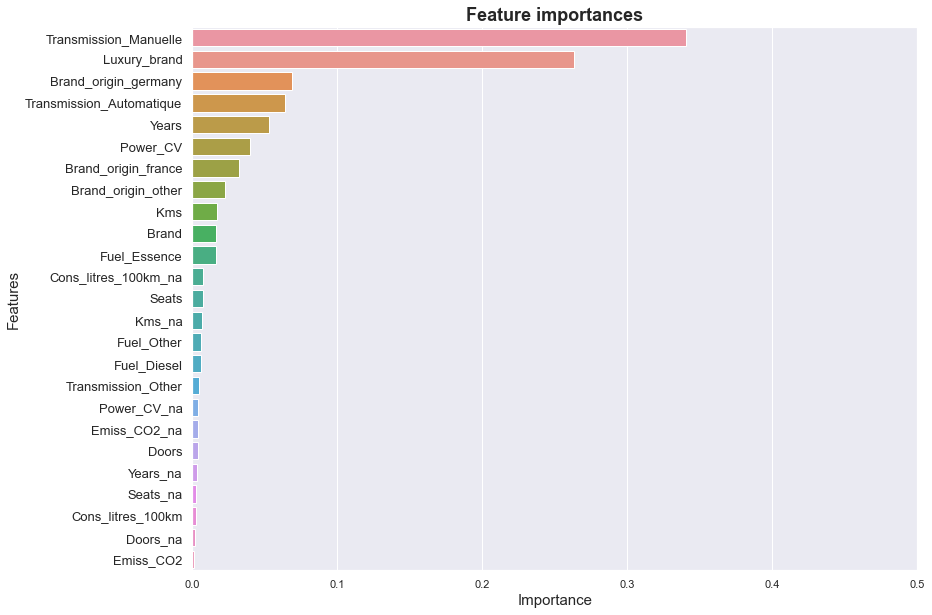

In [20]:
plt.figure(figsize = (13,10))

sns.barplot(y=df_model.features, x=df_model.importance)

plt.title('Feature importances', weight = 'bold', size = 18)
plt.yticks(fontsize = 13)
plt.xticks(np.arange(0,0.6,0.1))
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.show()